This code is inspired from the code available here: https://www.kaggle.com/leighplt/pytorch-fcn-resnet50

# Import libraries

In [2]:
import numpy as np
import pandas as pd
import pathlib, sys, os, random, time
import numba, cv2, gc

import seaborn as sn
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import statistics
import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

import albumentations as A

In [3]:
import rasterio
from rasterio.windows import Window

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

import torchvision
from torchvision import transforms as T

# Configuration 

In [4]:
def set_seeds(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seeds();

In [5]:
DATA_PATH = 'hubmap-kidney-segmentation/hubmap-kidney-segmentation_original'
EPOCHS =20
BATCH_SIZE = 8
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu' 

# UDF

In [6]:
# used for converting the decoded image to rle mask
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(256, 256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

@numba.njit()     # https://numba.pydata.org/numba-doc/latest/user/5minguide.html
def rle_numba(pixels):
    size = len(pixels)
    points = []
    if pixels[0] == 1:
        flag = False
        points.append(1)
    else:
        flag = True
    for i in range(1, size):
        if pixels[i] != pixels[i-1]:
            if flag:
                points.append(i+1)
                flag = False
            else:
                points.append(i+1 - points[-1])
                flag = True
    if pixels[-1] == 1: points.append(size-points[-1]+1)    
    return points

def rle_numba_encode(image):
    pixels = image.flatten(order = 'F')
    points = rle_numba(pixels)
    return ' '.join(str(x) for x in points)

def make_grid(shape, window=256, min_overlap=32):
    """
        Return Array of size (N,4), where N - number of tiles,
        2nd axis represente slices: x1,x2,y1,y2 
    """
    x, y = shape
    nx = x // (window - min_overlap) + 1
    x1 = np.linspace(0, x, num=nx, endpoint=False, dtype=np.int64)
    x1[-1] = x - window
    x2 = (x1 + window).clip(0, x)
    ny = y // (window - min_overlap) + 1
    y1 = np.linspace(0, y, num=ny, endpoint=False, dtype=np.int64)
    y1[-1] = y - window
    y2 = (y1 + window).clip(0, y)
    slices = np.zeros((nx,ny, 4), dtype=np.int64)
    
    for i in range(nx):
        for j in range(ny):
            slices[i,j] = x1[i], x2[i], y1[j], y2[j]    
    return slices.reshape(nx*ny,4)

In [7]:
identity = rasterio.Affine(1, 0, 0, 0, 1, 0)

class HubDataset(D.Dataset):

    def __init__(self, root_dir, transform,
                 window=256, overlap=64, threshold = 500):
        self.path = pathlib.Path(root_dir)
        self.overlap = overlap
        self.window = window
        self.transform = transform
        self.csv = pd.read_csv((self.path / 'train.csv').as_posix(),
                               index_col=[0])
        self.threshold = threshold
        self.build_slices()
        self.len = len(self.slices)
        self.as_tensor = T.Compose([
            T.ToTensor(),
            T.Normalize([0.625, 0.448, 0.688],
                        [0.131, 0.177, 0.101]),
        ])
    def build_slices(self):
        self.masks = []
        self.files = []
        self.slices = []
        for i, filename in enumerate(self.csv.index.values):
            filepath = (self.path /'train'/(filename+'.tiff')).as_posix()
            self.files.append(filepath)
            with rasterio.open(filepath, transform = identity) as dataset:
                self.masks.append(rle_decode(
                    self.csv.loc[filename, 'encoding'], dataset.shape))
                slices = make_grid(dataset.shape, window=self.window,
                                   min_overlap=self.overlap)
                for slc in slices:
                    x1,x2,y1,y2 = slc
                    if self.masks[-1][x1:x2,y1:y2].sum() > self.threshold:
                        self.slices.append([i,x1,x2,y1,y2])
                        
    # get data operation
    def __getitem__(self, index):
        
        idx = self.slices[index][0]
        filename = self.files[idx]
        x1,x2,y1,y2 = self.slices[index][1:] 
        with rasterio.open(filename, transform = identity) as dataset:
            channels = [1,2,3] if dataset.count == 3 else [1,1,1]
            image = dataset.read(channels,window=Window.from_slices((x1,x2),(y1,y2)))    
            image = np.moveaxis(image, 0, -1)
            
        mask = self.masks[idx][x1:x2,y1:y2]
        
        augments = self.transform(image=image, mask=mask)
        return self.as_tensor(augments['image']), augments['mask'][None]
    
    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

# Data

## Data Cleaning

In [8]:
HuBMAP_DS_information = pd.read_csv(DATA_PATH+"/HuBMAP-20-dataset_information.csv") 
df_info=HuBMAP_DS_information
df_info_idx= []
list1=["57512b7f1.tiff","3589adb90.tiff","aa05346ff.tiff","2ec3f1bb9.tiff","d488c759a.tiff"]
for i in range(len(df_info)):
    if df_info["image_file"][i] in list1:
        df_info_idx.append(i)
df_info_idx
df_info=df_info.drop(df_info.index[df_info_idx])
len(df_info)

15

## Data processing

In [9]:
WINDOW=1024
MIN_OVERLAP=32
NEW_SIZE=256

trfm = A.Compose([
    A.Resize(NEW_SIZE,NEW_SIZE),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter (brightness=0.07, contrast=0.07,
                   saturation=0.1, hue=0.1, always_apply=False, p=0.3)
])

ds = HubDataset(DATA_PATH, window=WINDOW, overlap=MIN_OVERLAP, transform=trfm)

## Split train, validation and test

In [10]:
valid_idx, train_idx, test_idx = [], [], []
for i in range(len(ds)):
    if ds.slices[i][0] == 4 :
        valid_idx.append(i)
    else:
        if ds.slices[i][0] == 8:
            test_idx.append(i)
        else:
            train_idx.append(i)
            
train_ds = D.Subset(ds, train_idx)
valid_ds = D.Subset(ds, valid_idx)
test_ds = D.Subset(ds, test_idx)
print("train_size: ",len(train_idx), "\nvalidation_size: ",len(valid_idx),"\ntest_size: ",len(test_idx) )

train_size:  3255 
validation_size:  349 
test_size:  417


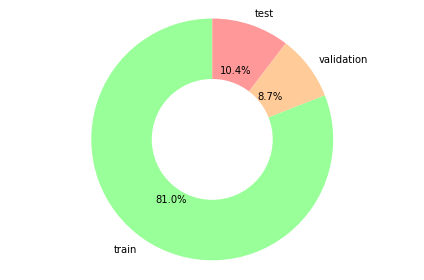

In [11]:
# Pie chart
labels = ['train', 'validation','test']
sizes = [len(train_idx), len(valid_idx),  len(test_idx)]
#colors
colors = ['#99ff99' ,'#ffcc99', '#ff9999','#66b3ff']
 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.5,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()

In [12]:
# define training and validation data loaders
loader = D.DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
vloader = D.DataLoader(
    valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
tloader = D.DataLoader(
    test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

## Input data visualization

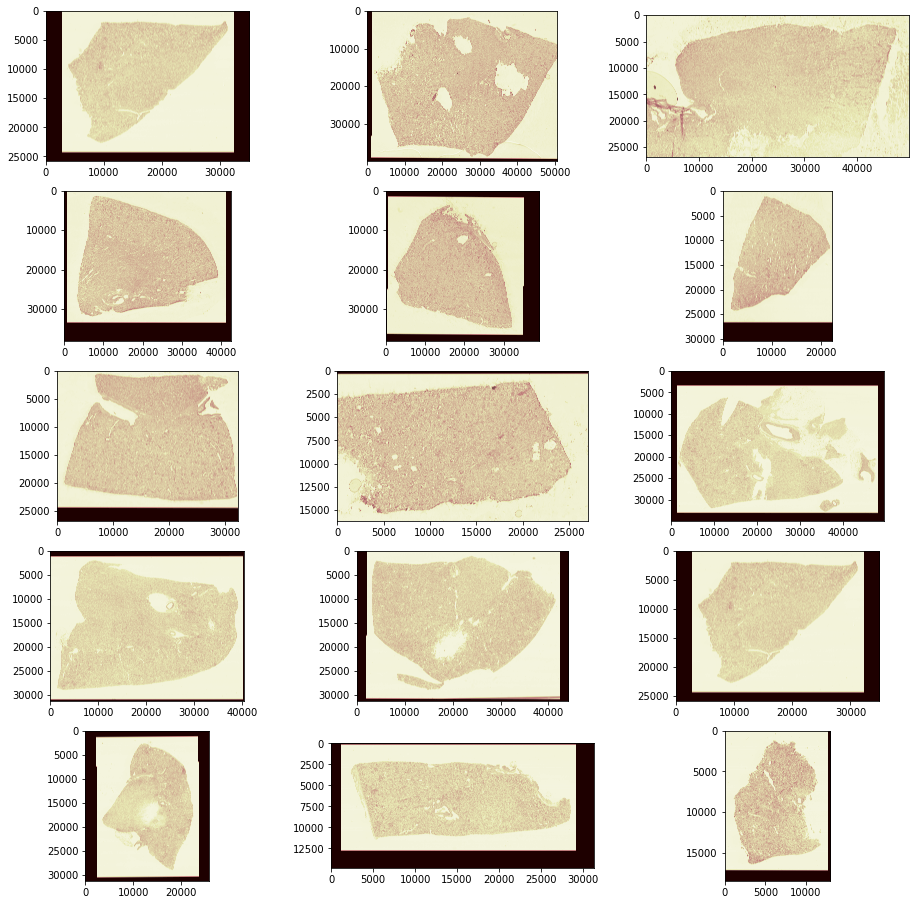

In [13]:
from matplotlib import pyplot
plt.figure(figsize=(16, 16))

plt.subplot(5, 3, 1)
ImagePath=DATA_PATH+'/train/0486052bb.tiff'
src = rasterio.open(ImagePath)
pyplot.imshow(src.read(1), cmap='pink')

plt.subplot(5, 3, 2)
ImagePath=DATA_PATH+'/train/4ef6695ce.tiff'
src = rasterio.open(ImagePath)
pyplot.imshow(src.read(1), cmap='pink')

plt.subplot(5, 3, 3)
ImagePath=DATA_PATH+'/train/c68fe75ea.tiff'
src = rasterio.open(ImagePath)
pyplot.imshow(src.read(1), cmap='pink')

plt.subplot(5, 3, 4)
ImagePath=DATA_PATH+'/train/26dc41664.tiff'
src = rasterio.open(ImagePath)
pyplot.imshow(src.read(1), cmap='pink')

plt.subplot(5, 3, 5)
ImagePath=DATA_PATH+'/train/095bf7a1f.tiff'
src = rasterio.open(ImagePath)
pyplot.imshow(src.read(1), cmap='pink')

plt.subplot(5, 3, 6)
ImagePath=DATA_PATH+'/train/54f2eec69.tiff'
src = rasterio.open(ImagePath)
pyplot.imshow(src.read(1), cmap='pink')

plt.subplot(5, 3, 7)
ImagePath=DATA_PATH+'/train/1e2425f28.tiff'
src = rasterio.open(ImagePath)
pyplot.imshow(src.read(1), cmap='pink')

plt.subplot(5, 3, 8)
ImagePath=DATA_PATH+'/train/e79de561c.tiff'
src = rasterio.open(ImagePath)
pyplot.imshow(src.read(1), cmap='pink')

plt.subplot(5, 3, 9)
ImagePath=DATA_PATH+'/train/cb2d976f4.tiff'
src = rasterio.open(ImagePath)
pyplot.imshow(src.read(1), cmap='pink')

plt.subplot(5, 3, 10)
ImagePath=DATA_PATH+'/train/b9a3865fc.tiff'
src = rasterio.open(ImagePath)
pyplot.imshow(src.read(1), cmap='pink')

plt.subplot(5, 3, 11)
ImagePath=DATA_PATH+'/train/8242609fa.tiff'
src = rasterio.open(ImagePath)
pyplot.imshow(src.read(1), cmap='pink')

plt.subplot(5, 3, 12)
ImagePath=DATA_PATH+'/train/0486052bb.tiff'
src = rasterio.open(ImagePath)
pyplot.imshow(src.read(1), cmap='pink')

plt.subplot(5, 3, 13)
ImagePath=DATA_PATH+'/train/2f6ecfcdf.tiff'
src = rasterio.open(ImagePath)
pyplot.imshow(src.read(1), cmap='pink')

plt.subplot(5, 3, 14)
ImagePath=DATA_PATH+'/train/b2dc8411c.tiff'
src = rasterio.open(ImagePath)
pyplot.imshow(src.read(1), cmap='pink')

plt.subplot(5, 3, 15)
ImagePath=DATA_PATH+'/train/aaa6a05cc.tiff'
src = rasterio.open(ImagePath)
pyplot.imshow(src.read(1), cmap='pink')
pyplot.show()

# Model 

In [15]:
def get_model():
    model = torchvision.models.segmentation.fcn_resnet101(True)
    model.classifier[4] = nn.Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
    model.aux_classifier[4] = nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
    return model

In [16]:
model = get_model()
model.to(DEVICE);
optimizer = torch.optim.AdamW(model.parameters(),
                  lr=1e-4, weight_decay=1e-3)

In [18]:
@torch.no_grad()
def validation(model, loader, loss_fn):
    losses = []
    dice_values = []

    model.eval()
    for image, target in loader:
        image, target = image.to(DEVICE), target.float().to(DEVICE)
        output = model(image)['out']
        loss = loss_fn(output, target)
        dice =1- dice_fn(output.sigmoid(), target)
        losses.append(loss.item())
        dice_values.append(dice.item())
        
    return np.array(losses).mean(),np.array(dice_values).mean()

In [19]:
class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1., dims=(-2,-1)):

        super(SoftDiceLoss, self).__init__()
        self.smooth = smooth
        self.dims = dims
    
    def forward(self, x, y):

        tp = (x * y).sum(self.dims)
        fp = (x * (1 - y)).sum(self.dims)
        fn = ((1 - x) * y).sum(self.dims)
        
        dc = (2 * tp + self.smooth) / (2 * tp + fp + fn + self.smooth)
        dc = dc.mean()

        return 1 - dc

In [20]:
bce_fn = nn.BCEWithLogitsLoss()
dice_fn = SoftDiceLoss()

def loss_fn(y_pred, y_true):
    bce = bce_fn(y_pred, y_true)
    dice = dice_fn(y_pred.sigmoid(), y_true)
    return 0.8*bce+ 0.2*dice

## train model

In [21]:
### Table for results
header = r'''
        Train         | Valid
Epoch |  Loss |  dice |  Loss |  dice | Time, m
'''
#          Epoch         metrics            time
raw_line = '{:6d}' + '\u2502{:7.3f}'*4 + '\u2502{:6.2f}'

In [22]:
print(header)
epochs=[]
TrainLoss=[]
TrainDice=[]
ValidLoss=[]
ValidDice=[]
TrainLossMedian=[]
TrainDiceMedian=[]
times=[]

for epoch in range(1, EPOCHS+1):
    losses = []
    dice_values=[]
  
    start_time = time.time()
    model.train()
    for image, target in loader:
        i=0
        image, target = image.to(DEVICE), target.float().to(DEVICE)
        optimizer.zero_grad()
        output = model(image)['out']
        loss = loss_fn(output, target)
        dice = 1- dice_fn(output.sigmoid(), target)

        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        dice_values.append(dice.item())
        
    vloss,vdice= validation(model, vloader, loss_fn)
    print(raw_line.format(epoch, np.array(losses).mean(),np.array(dice_values).mean(), vloss,vdice,
                              (time.time()-start_time)/60**1))    
    epochs.append(epoch)
    TrainLoss.append(np.array(losses).mean())
    TrainDice.append(np.array(dice_values).mean())
    TrainLossMedian.append(statistics.median(np.array(losses)))
    TrainDiceMedian.append(statistics.median(np.array(dice_values)))
    ValidLoss.append(vloss)
    ValidDice.append(vdice)
    times.append((time.time()-start_time)/60**1)

    losses = []
    dice_values= []


        Train         | Valid
Epoch |  Loss |  dice |  Loss |  dice | Time, m

     1│  0.233│  0.477│  0.110│  0.698│ 11.96
     2│  0.096│  0.721│  0.070│  0.814│ 11.40
     3│  0.074│  0.789│  0.054│  0.864│ 11.20
     4│  0.064│  0.822│  0.057│  0.866│ 11.17
     5│  0.058│  0.840│  0.052│  0.874│ 11.49
     6│  0.056│  0.848│  0.055│  0.873│ 17.51
     7│  0.052│  0.860│  0.053│  0.873│ 19.11
     8│  0.048│  0.869│  0.048│  0.892│ 12.63
     9│  0.047│  0.874│  0.060│  0.858│ 11.45
    10│  0.048│  0.871│  0.052│  0.878│ 11.67
    11│  0.045│  0.880│  0.054│  0.875│ 15.30
    12│  0.042│  0.884│  0.052│  0.887│ 15.47
    13│  0.044│  0.883│  0.050│  0.891│ 15.01
    14│  0.041│  0.889│  0.051│  0.889│ 14.12
    15│  0.039│  0.896│  0.053│  0.886│ 12.16
    16│  0.036│  0.903│  0.053│  0.889│ 10.76
    17│  0.036│  0.905│  0.054│  0.885│ 14.83
    18│  0.037│  0.903│  0.049│  0.897│ 16.91
    19│  0.034│  0.909│  0.053│  0.893│ 15.11
    20│  0.037│  0.902│  0.061│  0.875│ 10.82


## Model output visualization

In [4]:
#Results: fcn_ResNet50 
epochs=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
times_ResNet50=[6.455233446756998,
 6.440150356292724,
 6.46369256178538,
 6.467632599671682,
 6.4955469806989035,
 6.445120028654734,
 6.539895296096802,
 6.515225025018056,
 6.506721671422323,
 6.519381296634674,
 6.507967444260915,
 6.498393265406291,
 6.529813313484192,
 6.520570898056031,
 6.490480915705363,
 6.455219173431397,
 6.501272654533386,
 6.505885263284047,
 6.505389352639516,
 6.399746568997701]

ValidDice_ResNet50=[0.7585050314664841,
 0.8213002356615934,
 0.8662306747653268,
 0.8722431348128752,
 0.8699255070903085,
 0.8797258152203127,
 0.8792263919656927,
 0.8920169581066478,
 0.8896389779719439,
 0.8890734978697516,
 0.8915222544561733,
 0.8853453072634611,
 0.8942934464324604,
 0.89094031940807,
 0.8905849483880129,
 0.8844803165305745,
 0.8899839154698632,
 0.8973949565128847,
 0.8895662887529894,
 0.8854954798113216]

TrainDice_ResNet50=[0.5275481892452193,
 0.7441005907421909,
 0.8028420458847533,
 0.8266571684024258,
 0.8414468921958961,
 0.8616662183616319,
 0.8625162943868145,
 0.8747674160858923,
 0.8791992252816146,
 0.8837173690959921,
 0.8853626741824044,
 0.890587047071949,
 0.8937432571183844,
 0.9013988347838493,
 0.8974382894923705,
 0.9056721672379121,
 0.9032798046269054,
 0.9032442823089019,
 0.9092903061053677,
 0.9112614388840791]

In [24]:
print('Execution time to train fcn-ResNet50 for 20 epochs:', sum(times_ResNet50))
print('Execution time to train fcn-ResNet101 for 20 epochs:', sum(times))

Execution time to train fcn-ResNet50 for 20 epochs: 129.76333811283112
Execution time to train fcn-ResNet101 for 20 epochs: 270.0819885253906


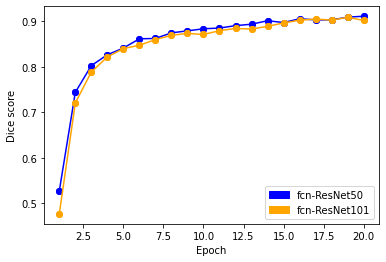

In [8]:
x = epochs
y1=TrainDice
z1 = ValidDice
y2=TrainDice_ResNet50
z2=ValidDice_ResNet50

y=y2
z=y1

plt.plot(x,y, 'o', color='blue');
plt.plot(x, y, '-ok', color='blue');
plt.plot(x, z, 'o', color='orange');
plt.plot(x, z, '-ok', color='orange');

trainDice50 = matplotlib.patches.Patch(color='blue', label='fcn-ResNet50')
trainDice101 = matplotlib.patches.Patch(color='orange', label='fcn-ResNet101')
plt.xlabel('Epoch')
plt.ylabel('Dice score')
plt.legend(handles=[trainDice50,trainDice101])

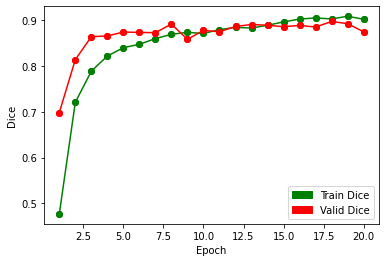

In [55]:
x = epochs
y=TrainDice
z = ValidDice
plt.plot(x,y, 'o', color='green');
plt.plot(x, y, '-ok', color='green');
plt.plot(x, z, 'o', color='red');
plt.plot(x, z, '-ok', color='red');

trainDice = matplotlib.patches.Patch(color='green', label='Train Dice')
validDice = matplotlib.patches.Patch(color='red', label='Valid Dice')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend(handles=[trainDice,validDice])

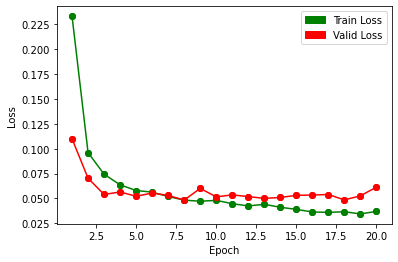

In [54]:
x = epochs
y=TrainLoss
z=ValidLoss
u=TrainLossMedian
plt.plot(x, y, 'o', color='green');
plt.plot(x, y, '-ok', color='green');
plt.plot(x, z, 'o', color='red');
plt.plot(x, z, '-ok', color='red')

trainLoss = matplotlib.patches.Patch(color='green', label='Train Loss')
validLoss = matplotlib.patches.Patch(color='red', label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(handles=[trainLoss,validLoss])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


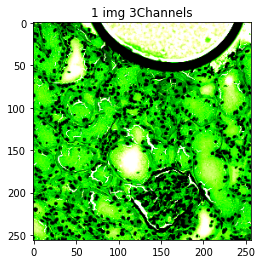

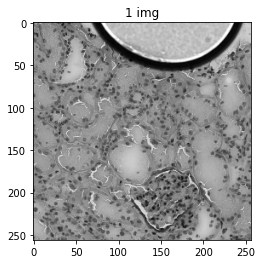

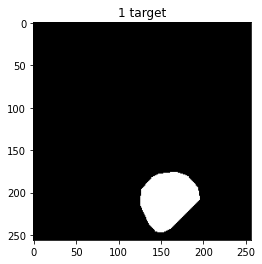

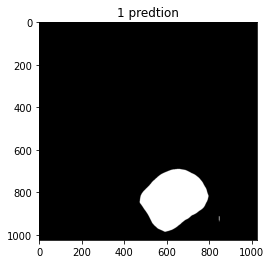

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])


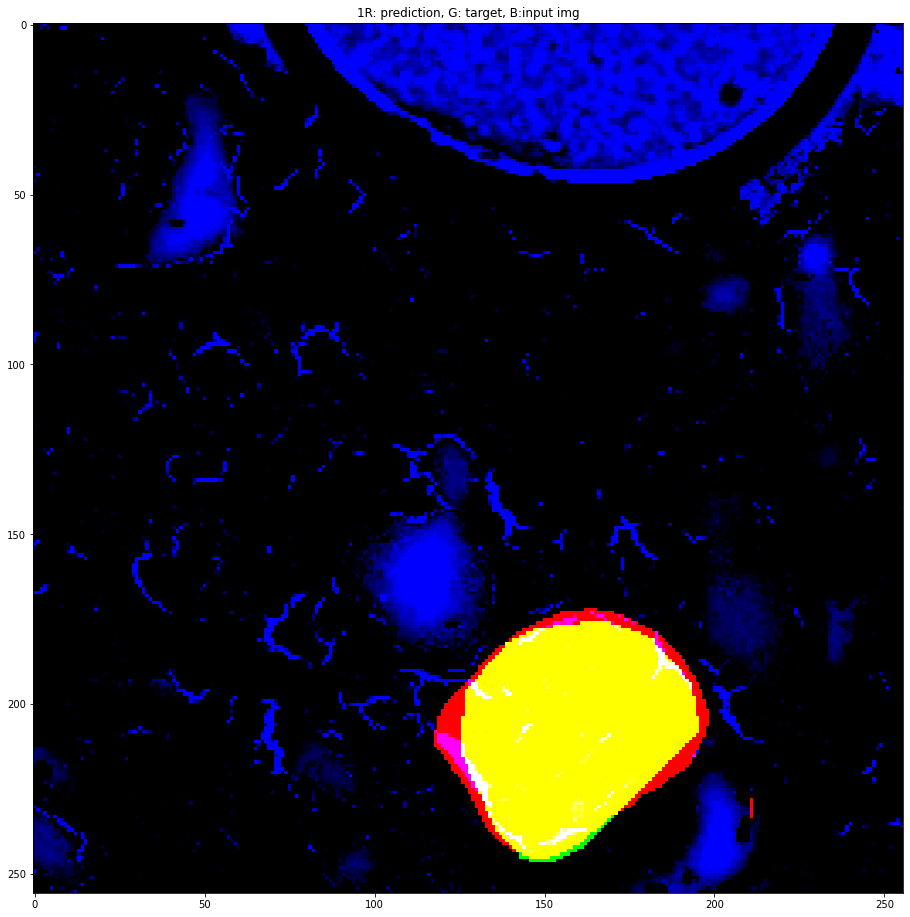

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


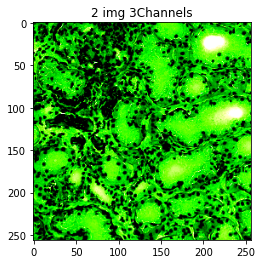

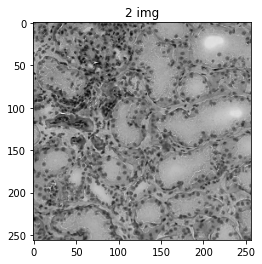

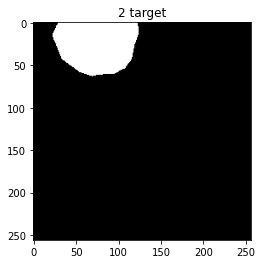

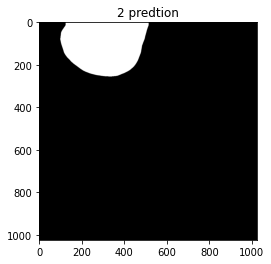

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])


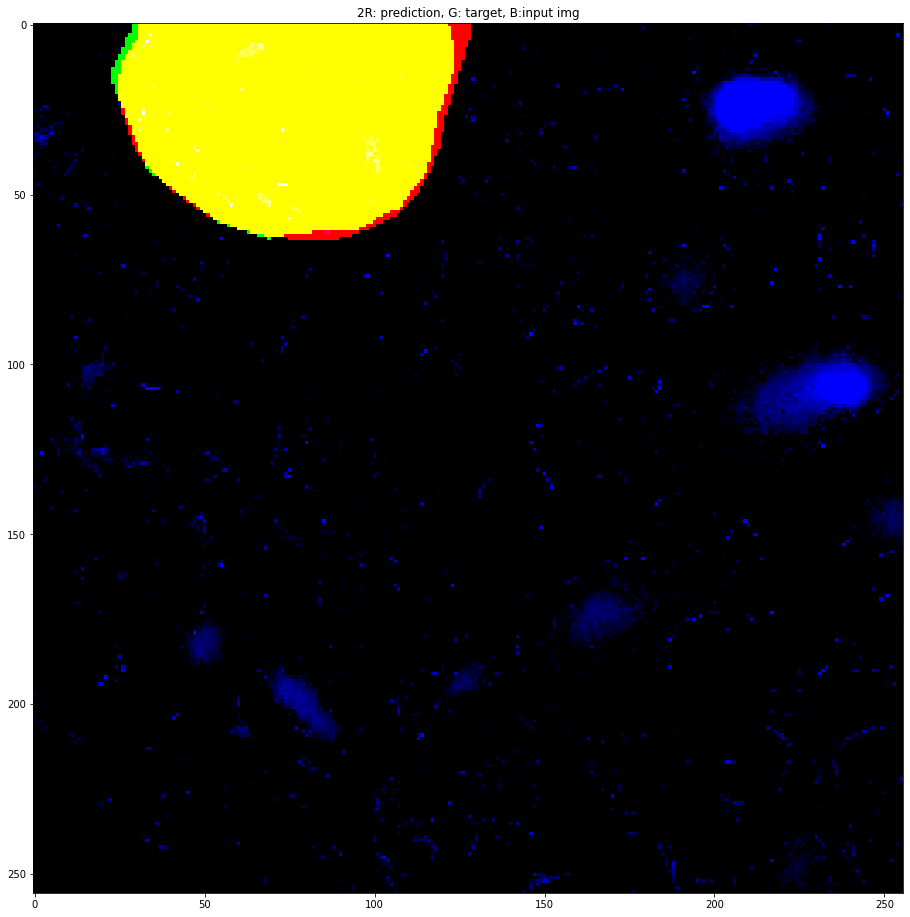

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


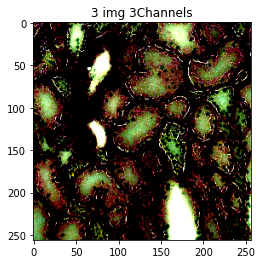

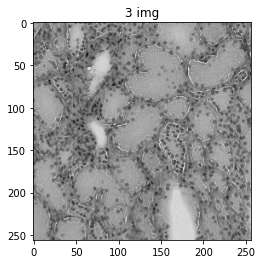

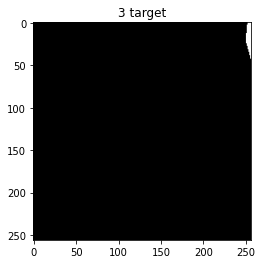

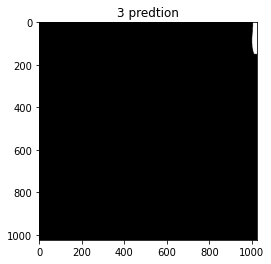

torch.Size([3, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


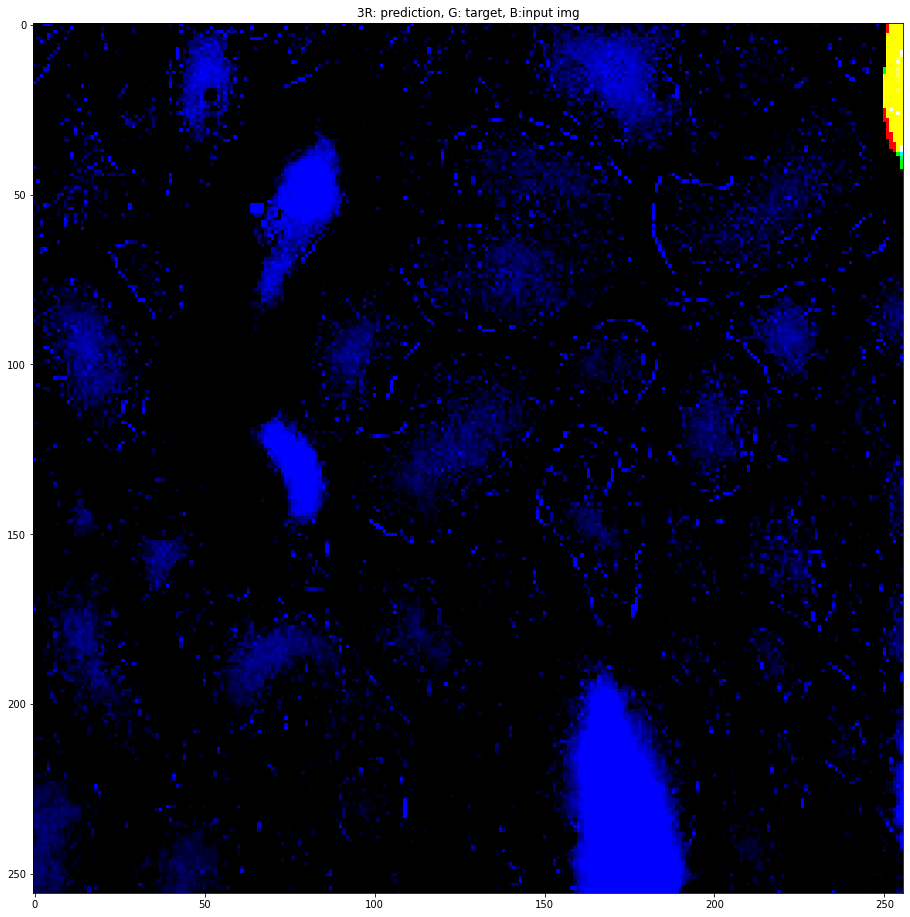

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


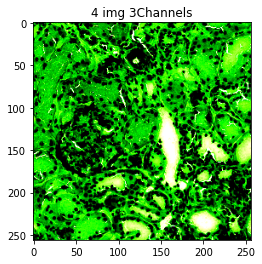

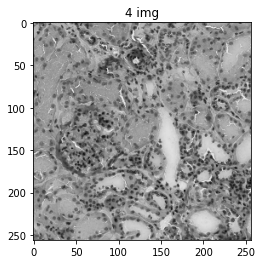

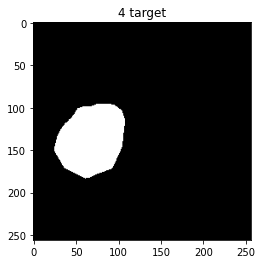

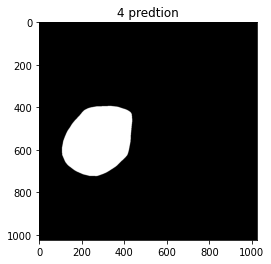

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])


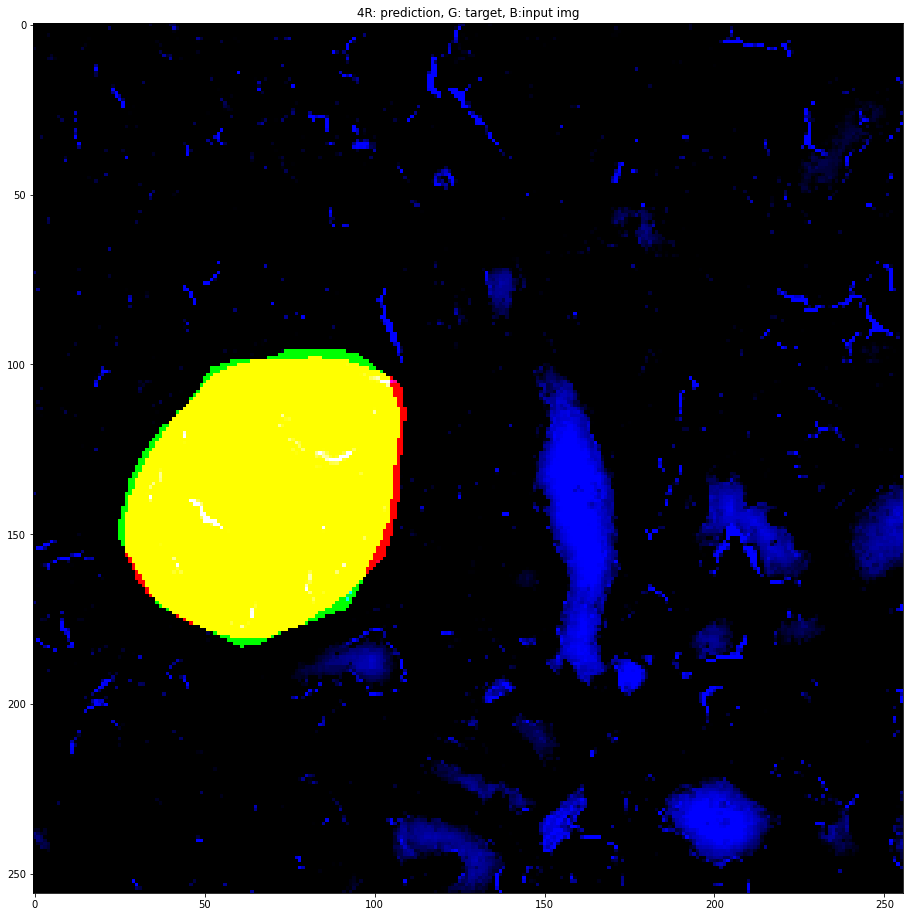

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


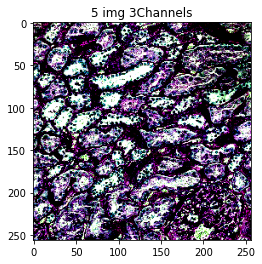

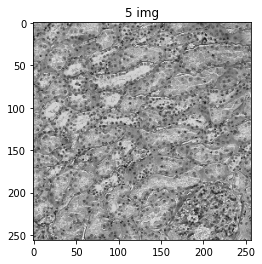

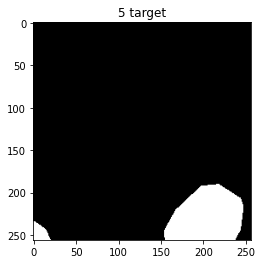

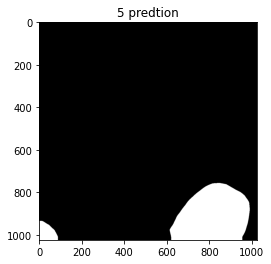

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])


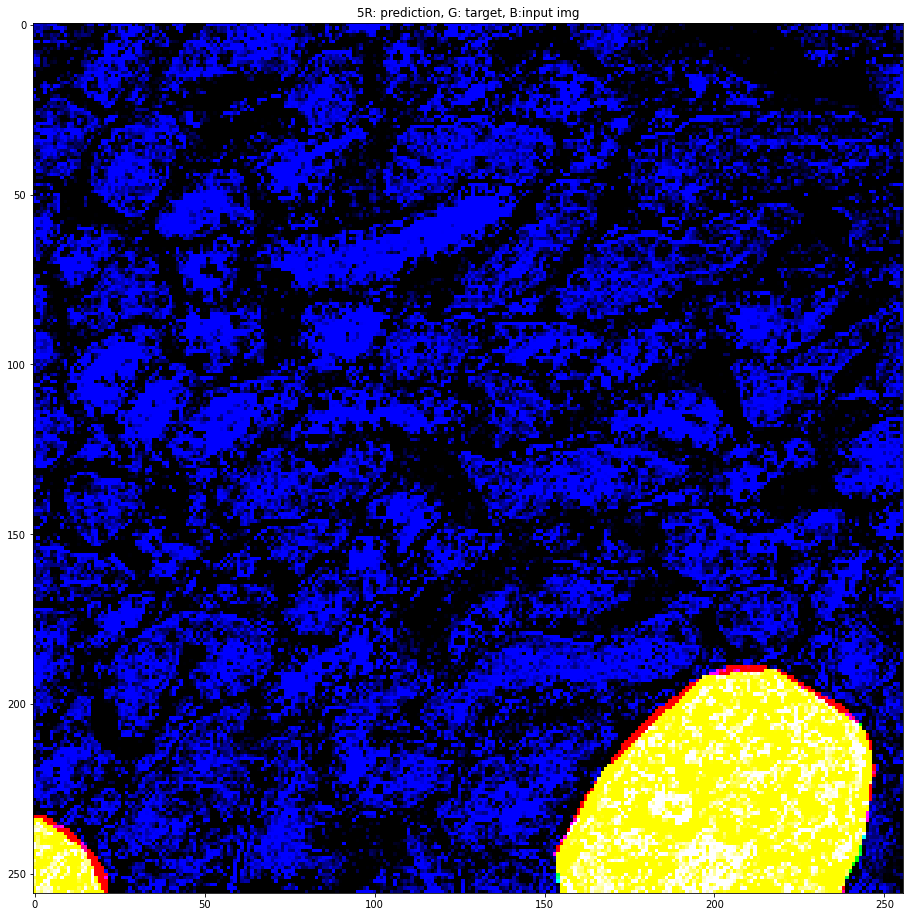

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


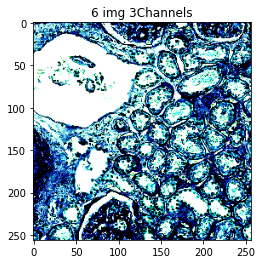

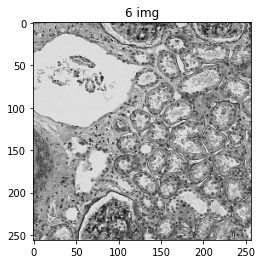

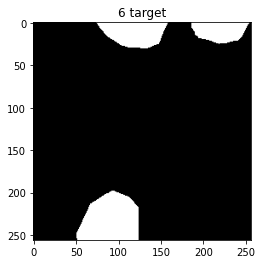

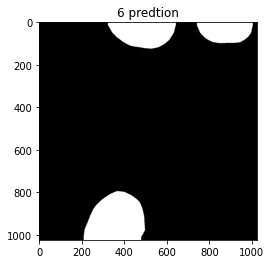

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])


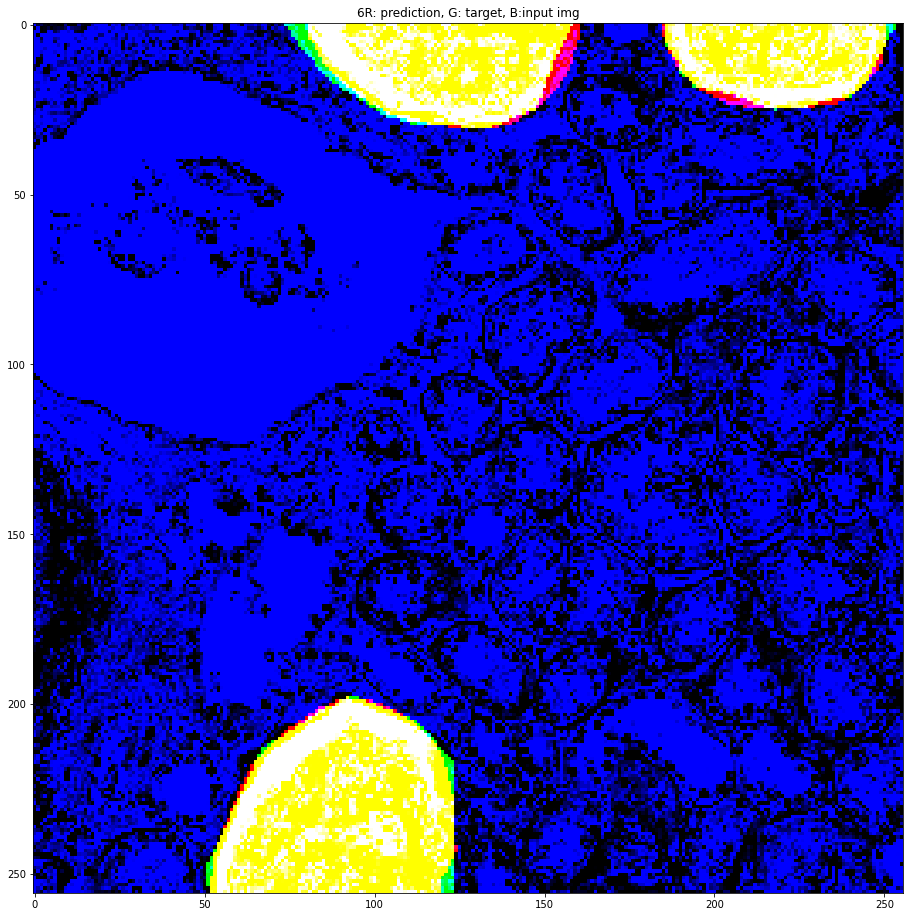

In [86]:
i=0

for image, target in loader:
        i+=1  
        img=image[0]
        img=img.permute(1, 2, 0)
        plt.imshow(img)
        plt.title(str(i)+' img 3Channels')
        plt.show()
        plt.imshow(image[0][0], cmap='gray')
        plt.title(str(i)+' img')
        plt.show()
        

        plt.imshow(target[0][0], cmap='gray')
        plt.title(str(i)+' target')
        plt.show()
        
        image = image.to(DEVICE)
        target = target.float().to(DEVICE)
        
        with torch.no_grad():
            #score = model(image.to(DEVICE)[None])['out'][0][0] # output = model(image)['out']
            score = model(image)['out'][0][0] # output = model(image)['out']
            score = score.cpu().numpy()
            score = cv2.resize(score, (WINDOW, WINDOW))
            predtion = (score > 0).astype(np.uint8)
            
            
            plt.imshow(predtion, cmap='gray')
            plt.title(str(i)+' predtion')
            plt.show()
        
        
            pred = cv2.resize(predtion, (256, 256)) #predtion.cpu().numpy() #((predtion)+img.min())/img.max()*250
            print(image[0].shape)
            image
            img = image[0].cpu().numpy() #np.moveaxis(image[0], 0,-1)
            img[0,:,:] = pred
            img[1,:,:] = target[0][0].cpu().numpy()
            #img = np.transpose(img)
            img = np.moveaxis(img, 0, -1) #.shape
            plt.figure(figsize=(16,16))
            plt.imshow(img)
            plt.title(str(i)+'R: prediction, G: target, B:input img')
            plt.show()


        if i>5:
            break;     

# Evaluation on test set

In [35]:
tloss,tdice= validation(model, tloader, loss_fn)
print("test_Loss: ",tloss,"test_Dice: ",tdice)

test_Loss:  0.08414540021627578 test_Dice:  0.8170191319483631
